In [ ]:
%%bash
sudo apt-get update
sudo apt-get install -y \
    texlive \
    texlive-latex-extra \
    texlive-fonts-recommended \
    texlive-fonts-extra \
    cm-super \
    dvipng


In [ ]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.latex.preamble": r"\usepackage{amsmath}",

    # --- FONT SIZE HIERARCHY ---
    "figure.titlesize": 16,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "legend.title_fontsize": 12,
})


## DIVON: Deterministic IVON with Variance-Guided Fine-Tuning

We propose **DIVON (Deterministic IVON)** — a lightweight extension that enables fast, single-pass deterministic inference while preserving key uncertainty-aware benefits of IVON.

DIVON begins from IVON’s posterior  
$$
q(\theta)={N}(m,\mathrm{diag}(\sigma^2)),
$$
and performs a short **variance-guided fine-tuning** phase on the posterior means \(m\), keeping \(\sigma^2\) fixed. Large variances indicate flat directions in the loss landscape, motivating a sensitivity penalty that encourages robustness along those directions.

The added regularizer is  
$$
{L}_{\text{reg}} = \alpha \sum_i \sigma_i^2
\left(
\frac{\partial f(x;m)}{\partial m_i}
\right)^2,
$$
yielding the deterministic objective
$$
{L}_{\text{DIVON}}
=
{L}_{\text{task}}
+
{L}_{\text{reg}}.
$$

Only the mean parameters are updated, and the required Hessian–vector product  
$H_f(m)(\sigma^2 \odot g)$  is computed efficiently using Pearlmutter’s trick.

Overall, DIVON transfers IVON’s posterior information into a **single-pass deterministic model**, achieving improved calibration without stochastic sampling at inference time.


In [ ]:
# !pip install torch --index-url https://download.pytorch.org/whl/cu118
!pip install ivon-opt


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import ivon
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import sys
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [ ]:

print("Python version:")
print(sys.version)

print("\nPyTorch version:")
print(torch.__version__)


Python version:
3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

PyTorch version:
2.9.0+cu126


### Loading, Splitting, and Preparing the CIFAR-10 Dataset

In [ ]:
# --- CIFAR-10 normalization ---
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# --- Load train set (used for both training and later fine-tuning) ---
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transform_train,
    download=True
)

# --- Load test set ---
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    transform=transform_test,
    download=True
)

# --- DataLoaders (batch_size = 50 to match IVON paper) ---
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=50, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=50, shuffle=False
)


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


### ResNet-20 Implementation

In [ ]:

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet20(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self._make_layer(16, 3, stride=1)
        self.layer2 = self._make_layer(32, 3, stride=2)
        self.layer3 = self._make_layer(64, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 10)

    def _make_layer(self, planes, blocks, stride):
        strides = [stride] + [1]*(blocks-1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return self.fc(out)


In [ ]:
def evaluate_probs(model, optimizer, loader, device, test_samples=0):
    """
    test_samples = 0 → IVON@mean        (deterministic mean weights)
    test_samples = 1 → single posterior sample
    test_samples > 1 → MC posterior averaging
    Deterministic optimizers automatically handled.
    """

    model.eval()
    all_probs, all_labels, all_logits = [], [], []
    ivon_mode = hasattr(optimizer, "sampled_params")

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)

            # ================================================
            # CASE A — IVON@mean (deterministic)
            # ================================================
            if ivon_mode and test_samples == 0:
                logits = model(X)
                probs = F.softmax(logits, dim=1)

            # ================================================
            # CASE B — IVON with posterior sampling
            # ================================================
            elif ivon_mode and test_samples >= 1:

                if test_samples == 1:
                    # single posterior sample
                    with optimizer.sampled_params(train=False):
                        logits = model(X)
                        probs = F.softmax(logits, dim=1)

                else:
                    # MC averaging
                    num_classes = model.fc.out_features if hasattr(model, "fc") else 10
                    mc_probs = torch.zeros(test_samples, X.size(0), num_classes, device=device)

                    for s in range(test_samples):
                        with optimizer.sampled_params(train=False):
                            mc_probs[s] = F.softmax(model(X), dim=1)

                    probs = mc_probs.mean(0)
                    logits = probs.log()  # logits not meaningful under MC, but needed for uniform API

            # ================================================
            # CASE C — Deterministic optimizers (SGD/AdamW/etc.)
            # ================================================
            else:
                logits = model(X)
                probs = F.softmax(logits, dim=1)

            all_probs.append(probs.cpu())
            all_logits.append(logits.cpu())
            all_labels.append(y.cpu())

    return torch.cat(all_probs), torch.cat(all_labels), torch.cat(all_logits)



# =======================================================================

def compute_ece(probs, labels, n_bins=15):
    confidences, preds = probs.max(dim=1)
    correctness = preds.eq(labels)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)

    ece = 0.0
    for i in range(n_bins):
        low, high = bin_boundaries[i], bin_boundaries[i+1]
        mask = (confidences >= low) & (confidences < high)
        if not mask.any():
            continue

        bin_conf = confidences[mask].mean()
        bin_acc = correctness[mask].float().mean()
        ece += mask.float().mean() * (bin_conf - bin_acc).abs()

    return float(ece)

# =======================================================================

def evaluate_all_metrics(model, optimizer, loader, device, test_samples=0):
    model.eval()

    probs, labels, logits = evaluate_probs(
        model, optimizer, loader, device, test_samples
    )

    # Top-1 accuracy
    top1 = (probs.argmax(1) == labels).float().mean().item()

    # Top-5 accuracy (safe for CIFAR-10 & larger datasets)
    top5 = (
        probs.topk(min(5, probs.size(1)), dim=1).indices
        .eq(labels.unsqueeze(1))
        .any(dim=1)
        .float()
        .mean()
        .item()
    )

    # True NLL (cross-entropy)
    nll = F.cross_entropy(logits, labels, reduction="mean").item()

    # ECE
    ece = compute_ece(probs, labels)

    # Brier score
    one_hot = F.one_hot(labels, probs.size(1)).float()
    brier = ((probs - one_hot) ** 2).mean().item()

    return {
        "Top-1 Acc ↑": top1,
        "Top-5 Acc ↑": top5,
        "NLL ↓": nll,
        "ECE ↓": ece,
        "Brier ↓": brier,
        "probs": probs,
        "labels": labels,
    }
#=========================================================================
def compare_methods(methods_dict, loader, device):
    """
    methods_dict example:
    {
        "IVON@mean": (model_ivon, optimizer_ivon, 0),
        "IVON-MC8":  (model_ivon, optimizer_ivon, 8),
        "SGD":       (model_sgd, optimizer_sgd, 0)
    }
    """

    rows = []

    for name, (model, optimizer, samples) in methods_dict.items():
        print(f"Evaluating {name} (samples={samples})...")

        metrics = evaluate_all_metrics(
            model=model,
            optimizer=optimizer,
            loader=loader,
            device=device,
            test_samples=samples
        )

        rows.append({
            "Method": name,
            "Top-1 Acc ↑": metrics["Top-1 Acc ↑"],
            "Top-5 Acc ↑": metrics["Top-5 Acc ↑"],
            "NLL ↓": metrics["NLL ↓"],
            "ECE ↓": metrics["ECE ↓"],
            "Brier ↓": metrics["Brier ↓"],
        })

    df = pd.DataFrame(rows).set_index("Method")
    print("\n=== Comparison Table ===")
    print(df)
    return df
#====================================================================

def plot_calibration_curve(probs, labels, n_bins=15, label_name="Model"):
    """
    Plots a reliability diagram (calibration curve) for a model.

    probs: tensor (N, C) with predicted probabilities
    labels: tensor (N,)
    """

    # Convert to numpy
    probs_np = probs.numpy()
    labels_np = labels.numpy()

    # Predicted confidence = max probability per sample
    confidences = np.max(probs_np, axis=1)

    # Predicted class
    predictions = np.argmax(probs_np, axis=1)

    # Correctness mask
    correctness = (predictions == labels_np).astype(int)

    # Compute calibration curve (fraction of positives vs confidence)
    frac_pos, mean_conf = calibration_curve(
        correctness,
        confidences,
        n_bins=n_bins,
        strategy='uniform'
    )

    # Plot
    plt.plot(mean_conf, frac_pos, marker="o", label=label_name)
    plt.plot([0, 1], [0, 1], "--", color="gray")  # perfect calibration
    plt.xlabel("Mean predicted confidence")
    plt.ylabel("Fraction of correct predictions")
    plt.title("Calibration Curve (Reliability Diagram)")
    plt.grid(True)


In [ ]:
# def train_ivon(train_samples=1, epochs=150):
#     model = ResNet20().to(device)
#     optimizer = ivon.IVON(model.parameters(), lr=0.1, ess=len(train_dataset))

#     for epoch in range(epochs):
#         model.train()
#         for X, y in train_loader:
#             X, y = X.to(device), y.to(device)
#             optimizer.zero_grad()
#             for _ in range(train_samples):
#                 with optimizer.sampled_params(train=True):
#                     logits = model(X)
#                     loss = F.cross_entropy(logits, y)
#                     loss.backward()
#             optimizer.step()
#     return model, optimizer

# model_ivon, optimizer_ivon = train_ivon(train_samples=s, epochs=150)
# ===========================================
# 1. Mount Google Drive
# ===========================================
from google.colab import drive
drive.mount('/content/drive')

# ===========================================
# 2. Define save directory
# ===========================================
save_dir = "/content/drive/MyDrive/Colab Notebooks/ADL/ivon-main"

# Optional: list contents
import os
print("Files in save_dir:", os.listdir(save_dir))

# ===========================================
# 3. Rebuild model architecture
# Make sure ResNet20() is already defined in your notebook.
# ===========================================
model_ivon = ResNet20().to(device)

# ===========================================
# 4. Rebuild optimizers exactly as during training
# ===========================================
# IVON optimizer
optimizer_ivon = ivon.IVON(
    model_ivon.parameters(),
    lr=0.1,
    ess=len(train_dataset)
)


# ===========================================
# 5. Load checkpoints
# ===========================================
# ----- IVON -----
ckpt = torch.load(f"{save_dir}/ivon_checkpoint2.pth", map_location=device)
model_ivon.load_state_dict(ckpt["model_state_dict"])
optimizer_ivon.load_state_dict(ckpt["optimizer_state_dict"])
print("Loaded IVON checkpoint")




Mounted at /content/drive
Files in save_dir: ['ID&OOD_uncertainty_eval_1.ipynb', '.gitignore', 'setup.py', 'LICENSE', 'ivon', 'logistic.ipynb', 'ivon_excluded_model.pth', 'sgd_excluded_model.pth', 'IVONrep.ipynb', 'ivon_checkpoint.pth', 'sgd_checkpoint.pth', 'adam_checkpoint.pth', 'MAP_vs_IVON', 'ID&OOD_uncertainty_eval2.ipynb', 'ivon_checkpoint8.pth', 'ID&OOD_uncertainty_eval.ipynb', 'ivon_checkpoint2.pth', 'sgd_checkpoint2.pth', 'adam_checkpoint2.pth']
Loaded IVON checkpoint


# DIVON: Deterministic IVON with Variance-Guided Fine-Tuning

In [ ]:
# =====================================================
# 1 Extract IVON posterior mean (m) and variance (sigma^2)
# =====================================================

# 1. Posterior mean m = model weights
ivon_means = [p.detach().clone() for p in model_ivon.parameters()]

# 2. Extract optimizer-level scalars
pg = optimizer_ivon.param_groups[0]

hess_flat   = pg["hess"]            # vector of curvature h
ess         = pg["ess"]             # expected sample size = 45000
delta       = pg["weight_decay"]    # damping = 1e-4

# Compute posterior variance: σ² = 1 / (λ (h + δ))
sigma2_flat = 1.0 / (ess * (hess_flat + delta))

# 3. Convert flat sigma² vector into per-parameter tensors
ivon_vars = []
idx = 0
for p in model_ivon.parameters():
    num = p.numel()
    s2 = sigma2_flat[idx : idx + num].view_as(p)
    ivon_vars.append(s2.clone().detach())
    idx += num

print("Extracted IVON posterior mean and variance!")


# ----------------------------------------------------------
# 2. Initialize DIVON model with IVON mean weights
# ----------------------------------------------------------
model_divon = ResNet20().to(device)

with torch.no_grad():
    for p, m in zip(model_divon.parameters(), ivon_means):
        p.copy_(m)


# ----------------------------------------------------------
# 3. Utility: compute f(x; m) and gradient g = ∂f/∂m
# ----------------------------------------------------------
def compute_f_and_grad(model, X):
    model.zero_grad()
    logits = model(X)

    # f(x; m) = mean predicted-class logit ( eq. 6)
    pred = logits.argmax(1)
    f = logits[torch.arange(len(logits)), pred].mean()

    params = [p for p in model.parameters() if p.requires_grad]
    g = torch.autograd.grad(f, params, create_graph=True)
    return f, g, logits


# ----------------------------------------------------------
# 4. One DIVON update step (full algorithm)
#    Implements eq. (6)-(10)
# ----------------------------------------------------------
def divon_step(model, opt, X, y, sigma2_list, alpha=1e-4):
    opt.zero_grad()

    # ----- main task loss -----
    logits = model(X)
    loss_task = F.cross_entropy(logits, y)

    # ----- compute f and full gradient list -----
    f, g_full, _ = compute_f_and_grad(model, X)

    params = list(model.parameters())

    # ----- replace None grads with zero tensors -----
    g = []
    v = []
    for gi, s2i, p in zip(g_full, sigma2_list, params):
        if gi is None:
            gi = torch.zeros_like(p)       # replace None
        g.append(gi)
        v.append(s2i * gi)

    # ----- Hessian–vector product (allow_unused=True) -----
    gv = sum([(gi * vi).sum() for gi, vi in zip(g, v)])

    hvp = torch.autograd.grad(
        gv,
        params,
        retain_graph=True,
        allow_unused=True
    )

    # Replace None entries in hvp with zeros
    hvp = [(h if h is not None else torch.zeros_like(p))
           for h, p in zip(hvp, params)]

    # ----- variance-guided regularizer term -----
    reg = sum([(s2i * (gi ** 2)).sum() for gi, s2i in zip(g, sigma2_list)])

    # ----- final loss -----
    loss = loss_task + alpha * reg
    loss.backward()
    opt.step()

    return loss.item(), loss_task.item()



# ----------------------------------------------------------
# 5. DIVON fine-tuning loop
# ----------------------------------------------------------
optimizer_divon = torch.optim.SGD(
    model_divon.parameters(),
    lr=1e-3,
    momentum=0.9
)

epochs = 5          # 1–10 usually enough
alpha = 1e-4        # DIVON regularization weight

for epoch in range(epochs):
    model_divon.train()
    losses = []

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        loss, ltask = divon_step(
            model_divon,
            optimizer_divon,
            X, y,
            ivon_vars,
            alpha
        )
        losses.append(loss)

    print(f"Epoch {epoch+1}/{epochs} | DIVON Loss: {sum(losses)/len(losses):.4f}")

print("DIVON training finished.")


Extracted IVON posterior mean and variance!
Epoch 1/5 | DIVON Loss: 0.1777
Epoch 2/5 | DIVON Loss: 0.1432
Epoch 3/5 | DIVON Loss: 0.1320
Epoch 4/5 | DIVON Loss: 0.1239
Epoch 5/5 | DIVON Loss: 0.1208
DIVON training finished.


### Evaluation


Running unified evaluation...

Evaluating DIVON (samples=0)...
Evaluating IVON@mean (samples=0)...
Evaluating IVON-MC8 (samples=8)...

=== Comparison Table ===
           Top-1 Acc ↑  Top-5 Acc ↑     NLL ↓     ECE ↓   Brier ↓
Method                                                           
DIVON           0.9123       0.9969  0.284055  0.030379  0.013093
IVON@mean       0.8720       0.9951  0.424658  0.043577  0.019070
IVON-MC8        0.8697       0.9950  0.414966  0.038392  0.018939
Plotting calibration curve for DIVON ...
Plotting calibration curve for IVON@mean ...
Plotting calibration curve for IVON-MC8 ...


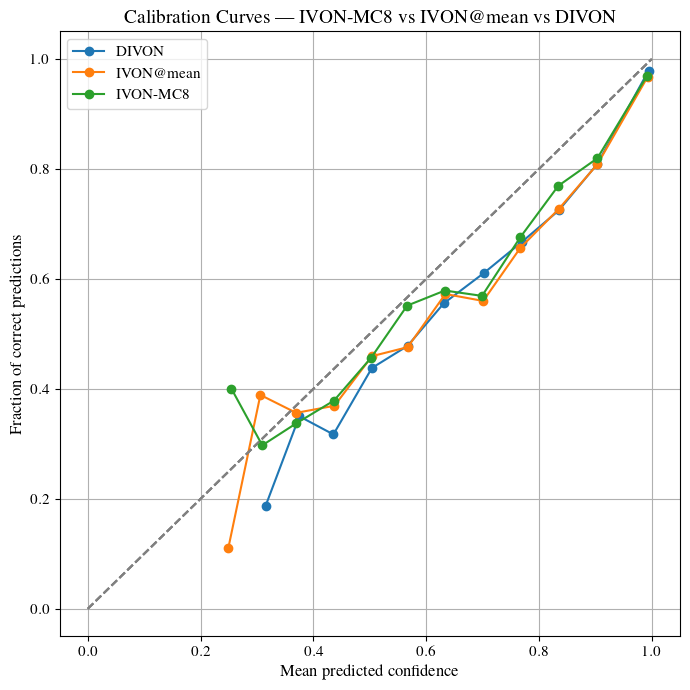

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Final Comparison Table:


,Top-1 Acc ↑,Top-5 Acc ↑,NLL ↓,ECE ↓,Brier ↓
Method,,,,,
DIVON,0.9123,0.9969,0.284055,0.030379,0.013093
IVON@mean,0.8720,0.9951,0.424658,0.043577,0.019070
IVON-MC8,0.8697,0.9950,0.414966,0.038392,0.018939


In [ ]:
# ============================================================
#   Unified Evaluation: IVON@mean vs IVON-MC vs DIVON
# ============================================================

print("\nRunning unified evaluation...\n")

methods = {
    "DIVON":      (model_divon, optimizer_divon, 0),   # deterministic
    "IVON@mean":  (model_ivon, optimizer_ivon,   0),   # mean weights
    "IVON-MC8":   (model_ivon, optimizer_ivon,   8),   # 8 posterior samples
}

df_results = compare_methods(methods, test_loader, device)

# ============================================================
#                   Calibration Curves
# ============================================================

plt.figure(figsize=(7,7))

for name, (model_m, optim_m, test_samples) in methods.items():
    print(f"Plotting calibration curve for {name} ...")

    probs, labels, _ = evaluate_probs(
        model_m,
        optim_m,
        test_loader,
        device,
        test_samples
    )

    plot_calibration_curve(
        probs,
        labels,
        n_bins=15,
        label_name=name
    )

plt.title("Calibration Curves — IVON-MC8 vs IVON@mean vs DIVON")
plt.legend()
plt.grid(True)

# ----- SAVE HERE BEFORE SHOW -----
plt.tight_layout()
plt.savefig("calibration_ivon_vs_divon.pdf", bbox_inches="tight")      # publication
#plt.savefig("calibration_ivon_vs_divon.png", dpi=300, bbox_inches="tight")  # preview

plt.show()

# Optional: for Google Colab
from google.colab import files
files.download("calibration_ivon_vs_divon.pdf")

# ============================================================
#                     Final Accuracy / ECE Table
# ============================================================

print("\nFinal Comparison Table:")
display(df_results)


### Out-of-Distribution Evaluation

In [ ]:
transform_svhn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std), # Re-using CIFAR-10 mean and std
])

# Load the SVHN test dataset
svhn_dataset = torchvision.datasets.SVHN(
    root='./data',
    split='test',
    transform=transform_svhn,
    download=True
)

# Create a DataLoader for the SVHN test dataset
svhn_loader = torch.utils.data.DataLoader(
    svhn_dataset,
    batch_size=50,
    shuffle=False
)

print("SVHN test dataset loaded and DataLoader created.")

100%|██████████| 64.3M/64.3M [00:16<00:00, 3.88MB/s]


SVHN test dataset loaded and DataLoader created.


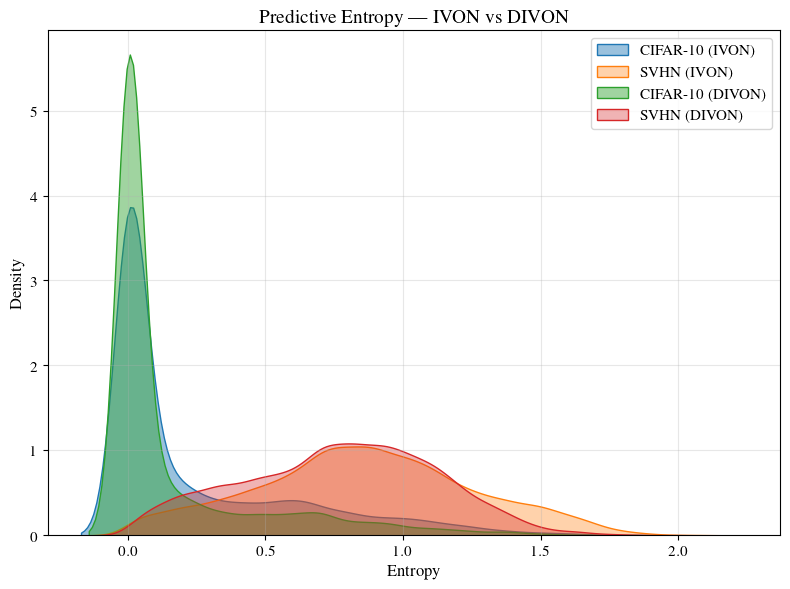

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --------------------------------------------------------------
# Predictive Entropy Functions
# --------------------------------------------------------------

# IVON entropy (uses optimizer.sampled_params)
def predictive_entropy(logits_mc):
    probs = logits_mc.softmax(dim=-1)
    entropy_per_sample = -(probs * (probs + 1e-12).log()).sum(dim=-1)  # [S, B]
    return entropy_per_sample.mean(dim=0).cpu().numpy()                # [B]


def get_entropy_ivon(model, optimizer, loader, mc_samples=8):
    model.eval()
    all_entropies = []

    with torch.no_grad():
        for X, _ in loader:
            X = X.to(device)

            logits_list = []
            for _ in range(mc_samples):
                with optimizer.sampled_params(train=False):
                    logits_list.append(model(X))

            logits_mc = torch.stack(logits_list, dim=0)   # [S, B, C]
            entropy = predictive_entropy(logits_mc)
            all_entropies.append(entropy)

    return np.concatenate(all_entropies)  # [N]


# DIVON entropy (deterministic forward pass)
def get_entropy_divon(model, loader):
    model.eval()
    all_entropies = []

    with torch.no_grad():
        for X, _ in loader:
            X = X.to(device)
            logits = model(X)
            probs = logits.softmax(dim=-1)
            entropy = -(probs * (probs + 1e-12).log()).sum(dim=-1)  # [B]
            all_entropies.append(entropy.cpu().numpy())

    return np.concatenate(all_entropies)


# --------------------------------------------------------------
# Compute All Entropies (IVON & DIVON)
# --------------------------------------------------------------

# ---- IVON ----
entropy_ivon = get_entropy_ivon(model_ivon, optimizer_ivon, test_loader)
entropy_svhn_ivon = get_entropy_ivon(model_ivon, optimizer_ivon, svhn_loader)

# ---- DIVON (deterministic, no optimizer needed) ----
entropy_divon = get_entropy_divon(model_divon, test_loader)
entropy_svhn_divon = get_entropy_divon(model_divon, svhn_loader)





# --------------------------------------------------------------
# Combined KDE Plot — IVON vs DIVON (CIFAR-10 + SVHN)
# --------------------------------------------------------------

plt.figure(figsize=(8,6))

# ---- IVON curves ----
sns.kdeplot(entropy_ivon,       fill=True, alpha=0.45, label="CIFAR-10 (IVON)")
sns.kdeplot(entropy_svhn_ivon,  fill=True, alpha=0.35, label="SVHN (IVON)")

# ---- DIVON curves ----
sns.kdeplot(entropy_divon,      fill=True, alpha=0.45, label="CIFAR-10 (DIVON)")
sns.kdeplot(entropy_svhn_divon, fill=True, alpha=0.35, label="SVHN (DIVON)")

plt.title("Predictive Entropy — IVON vs DIVON", fontsize=14)
plt.xlabel("Entropy", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# ---- SAVE BEFORE SHOW ----
plt.tight_layout()
plt.savefig("entropy_ivon_vs_divon.pdf", bbox_inches="tight")
#plt.savefig("entropy_ivon_vs_divon.png", dpi=300, bbox_inches="tight")

plt.show()

# Optional (Google Colab)
from google.colab import files
files.download("entropy_ivon_vs_divon.pdf")
